### Cab-Driver Agent

#### In this case agent we use model architecture for which we input only state and output is q_value of every possible action.
The advantage of this is just giving state as input state-value NN approximator function. We get output q_value for every possible action from this state. Here we have to run NN once for every state. 

In [16]:
# Importing libraries
import os
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [17]:
# Loading the time matrix provided
time_matrix = np.load("TM.npy")

In [18]:
directory_model = 'save_model'
directory_pickle_files = 'saved_pickle_files'

if not os.path.exists(directory_model):
    os.makedirs(directory_model)
    
if not os.path.exists(directory_pickle_files):
    os.makedirs(directory_pickle_files)

#### Tracking the state-action pairs for checking convergence

In [19]:
States_track = collections.defaultdict(dict)

In [20]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 6, 4), (0, 3)), ((0, 2, 1), (0, 4)), ((3, 22, 4), (2, 4)), ((1, 9, 1), (4, 0)), 
                       ((2, 20, 4), (3, 2)), ((2, 14, 1), (2, 4)), ((2, 14, 1), (0, 4)), ((3, 22, 4), (0, 4)),
                       ((2, 13, 4), (4, 2)), ((4, 23, 6), (2, 4)), ((3, 22, 6), (0, 4)), ((1, 9, 2), (0, 0)),
                       ((1, 11, 3), (1, 3)), ((0, 19, 4), (4, 1)), ((1, 23, 6), (2, 4))]
  
    for q_values in sample_q_values:
        state_val = q_values[0]
        action_val = q_values[1]
        # Initialize q-values and state
        States_track[state_val][action_val] = [] # This is an array which will have appended values of that state-action pair for every 2000th episode 

In [21]:
#  This function will be called end of every episode
def save_tracking_states(agent, env):
    for state_val in States_track.keys():
        for action_val in States_track[state_val].keys():
            input_data = env.state_encode_arch1(np.array(state_val))
            q_value = agent.model.predict(input_data)
            States_track[state_val][action_val].append(np.argmax(q_value[0]))

In [22]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [23]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, epsilon_decay=0.01, epsilon_min=0.001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate =  learning_rate
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self): 
        # The input The state space is defined by 
        # the driver’s current location along with the time components (hour-of-the-day and the day-of-the-week).
        input_shape = self.state_size
        
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        model.add(Dense(32, input_dim=input_shape, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # The output layer output of size of action_space
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model


    def get_action(self, state, env, episode_time):
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        action = None
        if np.random.rand() <= self.epsilon:
            # get possible action space for state
            actions = env.requests(state)
            action_index = np.random.choice(range(len(actions)))
            action = actions[action_index]
        else:
            #choose action index with highest q(s, a)
            input_state = env.state_encode_arch1(state)
            q_value = self.model.predict(input_state)
            action_index = np.argmax(q_value[0])
            action = env.action_space[action_index]
        
        # epsilon decay
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode_time)
        
        return action
 

    def append_sample(self, state, action_index, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s', terminal_state> to the replay memory
        self.memory.append((state, action_index, reward, next_state, terminal_state))
      
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self, env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            action_indices, rewards, terminal_states  = [], [], []
            
            for i in range(self.batch_size):
                state, action_index, reward, next_state, terminal_state = mini_batch[i]
                
                # Write your code from here
                update_input[i] = env.state_encode_arch1(state)
                action_indices.append(action_index)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                update_output[i] = env.state_encode_arch1(next_state)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Q Learning: get maximum Q value at s' from target model
                if terminal_states[i]:
                    target[i][action_indices[i]] = rewards[i]
                else:
                    target[i][action_indices[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save_model_weights(self, name):
        self.model.save_weights(name)

In [24]:
Episodes = 1000
total_hours_duration = 720 #30 * 24 hours
env = CabDriver(time_matrix)
state_size = env.state_size
action_size = len(env.action_space)

#Call the DQN agent
agent = DQNAgent(state_size, action_size)

rewards_per_episode= []

tracking_threshold = 50
# If driver drives continueously the maximum reward he can get in 30 days window is 720 * 9 - 720 * 5
# total per hour cost - total fuel cost
# we can stop traing if recent 20 epsiodes rewards reaches 95% of max_possible_reward
max_possible_reward = 720*9 - 720*5

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


### DQN block

In [25]:
start_time = time.time()
try:
    for episode in range(Episodes):

        elapsed_time = 0
        score = 0
        terminal_state = False
        state = env.reset()
        start_state = state

        while  not terminal_state:
            # Write your code here
            # 1. Pick epsilon-greedy action from possible actions for the current state
            action = agent.get_action(state, env, episode)
            # 2. Evaluate your reward and next state
            reward, next_state, step_duration = env.step(state, action)

            elapsed_time += step_duration
            # window duration is 30 days, The taxis are electric cars. It can run for 30 days non-stop, i.e., 24*30 hrs. 
            if(elapsed_time >= total_hours_duration):
                terminal_state = True

            # 3. Append the experience to the memory
            # print(env.action_space.index(action))
            action_index = env.action_space.index(action)
            agent.append_sample(state, action_index, reward, next_state, terminal_state)

            # 4. Train the model by calling function agent.train_model
            agent.train_model(env)

            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state


        # store total reward obtained in this episode
        rewards_per_episode.append(score)

        # every episode:
        print("episode {0}, Agent ride Start_state {1}, reward {2}, memory_length {3}, epsilon {4}".format(episode,
                                                                             start_state,
                                                                             score,
                                                                             len(agent.memory),
                                                                             agent.epsilon))
        # initialize tracking states
        if episode == (tracking_threshold - 1):
            initialise_tracking_states()
            
        # if the mean of scores of last 20 episode is bigger than 96% of max_possible_reward then
        # we can stop training
        if np.mean(rewards_per_episode[-min(20, len(rewards_per_episode)):]) >= (.95 * max_possible_reward):
            save_tracking_states(agent, env)
            agent.save_model_weights('./save_model/driver_dqn.h5')
            sys.exit(0)
            
        # save tracking states after every 50 episodes    
        if (episode + 1) % 50 == 0:
            save_tracking_states(agent, env)
            agent.save_model_weights('./save_model/driver_dqn.h5')
except:
    pass
elapsed_time = time.time() - start_time
print('Total time Elapsed for episodes: {0} training in seconds: {1}'.format(Episodes, elapsed_time))        

episode 0, Agent ride Start_state (1, 16, 1), reward 0.0, memory_length 147, epsilon 1.0
episode 1, Agent ride Start_state (2, 21, 3), reward -42.0, memory_length 296, epsilon 0.9900597839154189
episode 2, Agent ride Start_state (4, 2, 4), reward -70.0, memory_length 448, epsilon 0.9802184746334485
episode 3, Agent ride Start_state (0, 18, 2), reward -24.0, memory_length 577, epsilon 0.9704750880149596
episode 4, Agent ride Start_state (0, 1, 5), reward -231.0, memory_length 720, epsilon 0.9608286497131708
episode 5, Agent ride Start_state (4, 9, 1), reward 139.0, memory_length 860, epsilon 0.9512781950762133
episode 6, Agent ride Start_state (3, 7, 5), reward -95.0, memory_length 997, epsilon 0.9418227690506644
episode 7, Agent ride Start_state (4, 3, 1), reward -3.0, memory_length 1129, epsilon 0.9324614260860423
episode 8, Agent ride Start_state (4, 11, 3), reward -127.0, memory_length 1263, epsilon 0.9231932300402491
episode 9, Agent ride Start_state (2, 18, 6), reward -128.0, memo

episode 77, Agent ride Start_state (2, 23, 3), reward 1353.0, memory_length 2000, epsilon 0.46355005524291687
episode 78, Agent ride Start_state (4, 16, 4), reward 971.0, memory_length 2000, epsilon 0.4589476052939183
episode 79, Agent ride Start_state (4, 8, 6), reward 1308.0, memory_length 2000, epsilon 0.45439095048707345
episode 80, Agent ride Start_state (4, 16, 1), reward 1323.0, memory_length 2000, epsilon 0.44987963515310436
episode 81, Agent ride Start_state (1, 5, 4), reward 1434.0, memory_length 2000, epsilon 0.44541320815671814
episode 82, Agent ride Start_state (3, 11, 3), reward 1453.0, memory_length 2000, epsilon 0.4409912228514932
episode 83, Agent ride Start_state (1, 7, 1), reward 1416.0, memory_length 2000, epsilon 0.43661323703521404
episode 84, Agent ride Start_state (0, 13, 6), reward 1028.0, memory_length 2000, epsilon 0.4322788129056506
episode 85, Agent ride Start_state (0, 11, 0), reward 1791.0, memory_length 2000, epsilon 0.427987517016778
episode 86, Agent r

episode 152, Agent ride Start_state (0, 2, 1), reward 1791.0, memory_length 2000, epsilon 0.21949317506526253
episode 153, Agent ride Start_state (3, 4, 0), reward 2020.0, memory_length 2000, epsilon 0.21731913164869107
episode 154, Agent ride Start_state (4, 17, 5), reward 2079.0, memory_length 2000, epsilon 0.21516672032555095
episode 155, Agent ride Start_state (4, 22, 2), reward 2081.0, memory_length 2000, epsilon 0.2130357258529163
episode 156, Agent ride Start_state (1, 23, 3), reward 2151.0, memory_length 2000, epsilon 0.21092593512956395
episode 157, Agent ride Start_state (0, 19, 5), reward 2056.0, memory_length 2000, epsilon 0.20883713717466346
episode 158, Agent ride Start_state (3, 5, 1), reward 2158.0, memory_length 2000, epsilon 0.20676912310667855
episode 159, Agent ride Start_state (4, 23, 2), reward 1974.0, memory_length 2000, epsilon 0.2047216861224792
episode 160, Agent ride Start_state (0, 9, 6), reward 2407.0, memory_length 2000, epsilon 0.20269462147666073
episode

episode 227, Agent ride Start_state (4, 4, 5), reward 2293.0, memory_length 2000, epsilon 0.1042088679030171
episode 228, Agent ride Start_state (0, 5, 5), reward 2618.0, memory_length 2000, epsilon 0.1031819225088219
episode 229, Agent ride Start_state (2, 7, 1), reward 2242.0, memory_length 2000, epsilon 0.10216519539202952
episode 230, Agent ride Start_state (1, 8, 4), reward 2475.0, memory_length 2000, epsilon 0.1011585848790809
episode 231, Agent ride Start_state (3, 16, 2), reward 2372.0, memory_length 2000, epsilon 0.10016199030808601
episode 232, Agent ride Start_state (0, 20, 1), reward 2632.0, memory_length 2000, epsilon 0.09917531201875718
episode 233, Agent ride Start_state (3, 8, 1), reward 2375.0, memory_length 2000, epsilon 0.09819845134244323
episode 234, Agent ride Start_state (2, 13, 5), reward 2448.0, memory_length 2000, epsilon 0.09723131059226255
episode 235, Agent ride Start_state (2, 13, 6), reward 2321.0, memory_length 2000, epsilon 0.09627379305333407
episode 2

episode 302, Agent ride Start_state (1, 20, 6), reward 2515.0, memory_length 2000, epsilon 0.04975241714365095
episode 303, Agent ride Start_state (2, 9, 3), reward 2466.0, memory_length 2000, epsilon 0.0492673224879417
episode 304, Agent ride Start_state (3, 0, 2), reward 2172.0, memory_length 2000, epsilon 0.04878705460470417
episode 305, Agent ride Start_state (0, 12, 3), reward 2297.0, memory_length 2000, epsilon 0.048311565466749765
episode 306, Agent ride Start_state (1, 23, 0), reward 2396.0, memory_length 2000, epsilon 0.0478408075247685
episode 307, Agent ride Start_state (0, 16, 0), reward 2375.0, memory_length 2000, epsilon 0.04737473370257382
episode 308, Agent ride Start_state (0, 23, 5), reward 2696.0, memory_length 2000, epsilon 0.04691329739239516
episode 309, Agent ride Start_state (3, 9, 5), reward 2387.0, memory_length 2000, epsilon 0.04645645245021695
episode 310, Agent ride Start_state (1, 20, 5), reward 2562.0, memory_length 2000, epsilon 0.04600415319116424
episo

episode 376, Agent ride Start_state (0, 4, 0), reward 2587.0, memory_length 2000, epsilon 0.024260456634522105
episode 377, Agent ride Start_state (4, 2, 5), reward 2529.0, memory_length 2000, epsilon 0.024029011223938346
episode 378, Agent ride Start_state (4, 8, 4), reward 2470.0, memory_length 2000, epsilon 0.023799868733667878
episode 379, Agent ride Start_state (3, 20, 6), reward 2604.0, memory_length 2000, epsilon 0.023573006249270743
episode 380, Agent ride Start_state (4, 23, 2), reward 2307.0, memory_length 2000, epsilon 0.023348401084309425
episode 381, Agent ride Start_state (2, 17, 1), reward 2483.0, memory_length 2000, epsilon 0.02312603077808028
episode 382, Agent ride Start_state (2, 9, 3), reward 2373.0, memory_length 2000, epsilon 0.02290587309336735
episode 383, Agent ride Start_state (3, 7, 3), reward 2634.0, memory_length 2000, epsilon 0.022687906014218724
episode 384, Agent ride Start_state (1, 0, 5), reward 2520.0, memory_length 2000, epsilon 0.022472107743744835


episode 450, Agent ride Start_state (3, 12, 6), reward 2600.0, memory_length 2000, epsilon 0.012097887541704065
episode 451, Agent ride Start_state (3, 5, 4), reward 2560.0, memory_length 2000, epsilon 0.011987461715631073
episode 452, Agent ride Start_state (3, 2, 5), reward 2698.0, memory_length 2000, epsilon 0.011878134644885886
episode 453, Agent ride Start_state (3, 18, 5), reward 2787.0, memory_length 2000, epsilon 0.011769895396670341
episode 454, Agent ride Start_state (1, 18, 3), reward 2649.0, memory_length 2000, epsilon 0.011662733146969403
episode 455, Agent ride Start_state (0, 7, 6), reward 2468.0, memory_length 2000, epsilon 0.011556637179468802
episode 456, Agent ride Start_state (3, 15, 0), reward 2737.0, memory_length 2000, epsilon 0.011451596884483366
episode 457, Agent ride Start_state (0, 16, 4), reward 2528.0, memory_length 2000, epsilon 0.011347601757896082
episode 458, Agent ride Start_state (3, 23, 5), reward 2541.0, memory_length 2000, epsilon 0.01124464140010

episode 524, Agent ride Start_state (4, 2, 3), reward 2591.0, memory_length 2000, epsilon 0.006294956579034532
episode 525, Agent ride Start_state (3, 13, 5), reward 2677.0, memory_length 2000, epsilon 0.0062422708807822035
episode 526, Agent ride Start_state (1, 20, 5), reward 2461.0, memory_length 2000, epsilon 0.006190109413986526
episode 527, Agent ride Start_state (3, 18, 0), reward 2599.0, memory_length 2000, epsilon 0.006138466962457349
episode 528, Agent ride Start_state (0, 23, 6), reward 2625.0, memory_length 2000, epsilon 0.006087338361906491
episode 529, Agent ride Start_state (2, 23, 6), reward 2637.0, memory_length 2000, epsilon 0.006036718499431288
episode 530, Agent ride Start_state (4, 16, 1), reward 2609.0, memory_length 2000, epsilon 0.005986602313003307
episode 531, Agent ride Start_state (3, 19, 6), reward 2466.0, memory_length 2000, epsilon 0.005936984790962138
episode 532, Agent ride Start_state (1, 12, 4), reward 2531.0, memory_length 2000, epsilon 0.00588786097

episode 598, Agent ride Start_state (4, 5, 1), reward 2668.0, memory_length 2000, epsilon 0.0035262974659370262
episode 599, Agent ride Start_state (4, 12, 5), reward 2744.0, memory_length 2000, epsilon 0.003501160386151898
episode 600, Agent ride Start_state (0, 21, 6), reward 2646.0, memory_length 2000, epsilon 0.0034762734244896923
episode 601, Agent ride Start_state (4, 11, 2), reward 2698.0, memory_length 2000, epsilon 0.0034516340922335033
episode 602, Agent ride Start_state (0, 12, 5), reward 2627.0, memory_length 2000, epsilon 0.0034272399254295705
episode 603, Agent ride Start_state (0, 17, 0), reward 2656.0, memory_length 2000, epsilon 0.00340308848464089
episode 604, Agent ride Start_state (1, 11, 2), reward 2598.0, memory_length 2000, epsilon 0.003379177354703254
episode 605, Agent ride Start_state (0, 11, 2), reward 2685.0, memory_length 2000, epsilon 0.0033555041444837427
episode 606, Agent ride Start_state (3, 9, 5), reward 2785.0, memory_length 2000, epsilon 0.003332066

episode 672, Agent ride Start_state (2, 18, 0), reward 2803.0, memory_length 2000, epsilon 0.0022053316757440823
episode 673, Agent ride Start_state (3, 0, 6), reward 2838.0, memory_length 2000, epsilon 0.002193338425183034
episode 674, Agent ride Start_state (0, 6, 4), reward 2752.0, memory_length 2000, epsilon 0.002181464509458957
episode 675, Agent ride Start_state (1, 21, 6), reward 2754.0, memory_length 2000, epsilon 0.002169708741170383
episode 676, Agent ride Start_state (1, 7, 0), reward 2745.0, memory_length 2000, epsilon 0.0021580699447306868
episode 677, Agent ride Start_state (4, 2, 0), reward 2758.0, memory_length 2000, epsilon 0.002146546956250524
episode 678, Agent ride Start_state (4, 20, 5), reward 2653.0, memory_length 2000, epsilon 0.0021351386234214464
episode 679, Agent ride Start_state (3, 21, 4), reward 2694.0, memory_length 2000, epsilon 0.0021238438054006627
episode 680, Agent ride Start_state (3, 5, 2), reward 2712.0, memory_length 2000, epsilon 0.002112661372

In [26]:
States_track

defaultdict(dict,
            {(0, 6, 4): {(0, 3): [11, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
             (0, 2, 1): {(0, 4): [11, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3, 2, 2]},
             (3,
              22,
              4): {(2, 4): [16,
               15,
               5,
               6,
               6,
               15,
               15,
               15,
               15,
               16,
               6,
               15,
               16,
               15], (0, 4): [16,
               15,
               5,
               6,
               6,
               15,
               15,
               15,
               15,
               16,
               6,
               15,
               16,
               15]},
             (1,
              9,
              1): {(4, 0): [16, 6, 5, 6, 5, 20, 5, 5, 5, 1, 20, 5, 5, 1]},
             (2,
              20,
              4): {(3, 2): [11, 9, 11, 11, 9, 9, 11, 11, 9, 11, 9, 11, 12, 9]},
             (2,
              

In [28]:
# save rewards_per_episode
save_obj(rewards_per_episode, "saved_pickle_files/rewards_per_episode")
save_obj(States_track,'saved_pickle_files/States_tracked')

### Tracking Convergence

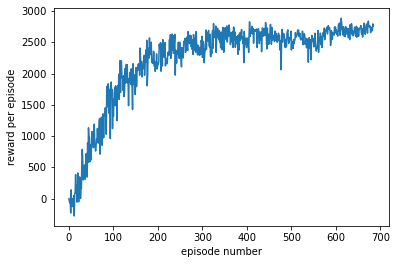

In [29]:
# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

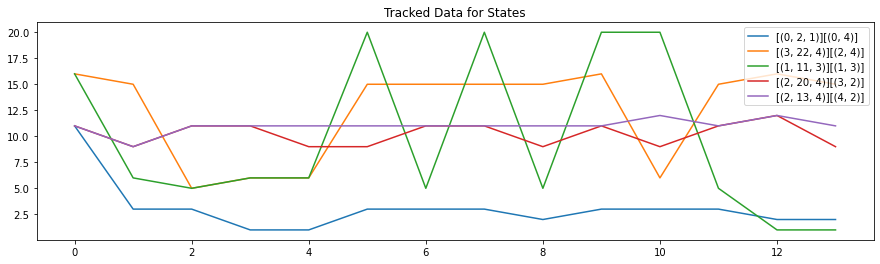

In [30]:
# Draw the plot using data captured through States_track for static states 
plt.figure(figsize=(15, 4))
plt.plot(States_track[(0, 2, 1)][(0, 4)], label = "[(0, 2, 1)][(0, 4)]")
plt.plot(States_track[(3, 22, 4)][(2, 4)], label = "[(3, 22, 4)][(2, 4)]")
plt.plot(States_track[(1, 11, 3)][(1, 3)], label = "[(1, 11, 3)][(1, 3)]")
plt.plot(States_track[(2, 20, 4)][(3, 2)], label = "[(2, 20, 4)][(3, 2)]")
plt.plot(States_track[(2, 13, 4)][(4, 2)], label = "[(2, 13, 4)][(4, 2)]")
plt.title('Tracked Data for States')
plt.legend()
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [31]:
time = np.arange(0,1000)
epsilon = []
for i in range(0,1000):
    epsilon.append(0.001 + (1 - 0.001) * np.exp(-0.01*i))

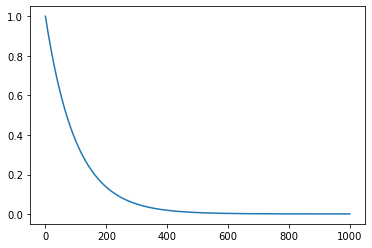

In [32]:
plt.plot(time, epsilon)
plt.show()